In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 256,
                 number_png_images_to_use_in_dataset=200*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.95,
                   
                load_vocabulary = False,


                 batch_size = 64,
                num_workers = 8,
                data_on_gpu = False,
                )


# Generates DataFrame
dataset.prepare_dataframe()

# prepeares the dataloaders with transformations and splits train/val
dataset.setup_data()

In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 179 
Max label length: 230 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:
# Initiate the model
model = ResNetTransformer(dataset=dataset).to(dev)



In [6]:
%load_ext tensorboard 
%tensorboard --logdir Models_Parameters_Log/

In [7]:
logger = TensorBoardLogger("Models_Parameters_Log", name="Test_Run")
lit_model = LitResNetTransformer(model=model)

#use the lit_model to run with Trainer
trainer = Trainer(accelerator='cpu', devices=0,  max_epochs=2, logger=logger, auto_lr_find=True) #accumulate_grad_batches=2, overfit_batches=1, default_root_dir="lightning_logs/ResNet/checkpoints"  
trainer.fit(model=lit_model, datamodule=dataset,)

#add parameter below to trainer.fit to continue from a checkpoint
#ckpt_path='lightning_logs/Character_tokenizer_1/version_2/checkpoints/epoch=0-step=1294.ckpt'
 #ckpt_path='lightning_logs/Character_tokenizer_1/version_4/checkpoints/epoch=15-step=20704.ckpt' )

wandb: Currently logged in as: gmarus (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name     | Type               | Params
------------------------------------------------
0 | model    | ResNetTransformer  | 3.7 M 
1 | loss_fn  | CrossEntropyLoss   | 0     
2 | val_cer  | CharacterErrorRate | 0     
3 | test_cer | CharacterErrorRate | 0     
------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.627    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/gregory/miniforge3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:393: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x108ecbca0>
Traceback (most recent call last):
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x108ecbca0>
Traceback (most recent call last):
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribut

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10f343ca0>
Traceback (most recent call last):
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10f343ca0>
Traceback (most recent call last):
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribut

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10fcbcca0>
Traceback (most recent call last):
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10fcbcca0>
Traceback (most recent call last):
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribut

/Users/gregory/miniforge3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10fa184c0>
Traceback (most recent call last):
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1468, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


In [12]:
import json

def save_dic(dic):
    filename = 'lightning_logs/256_character_1.json'
    with open(filename, 'w') as f:
        f.write(json.dumps(dic, default=str))

def load_dic(filename):
    with open(filename) as f:
        dic = json.loads(f.read())
    return dic


In [13]:
# save model
# torch.save(model.state_dict(), 'lightning_logs/256_character_1.pth')

# save vocabulary
# save_dic(data.vocabulary)

### TESTS
In the cell below we pass input and target through the model and check inference

In [14]:
# Helper Function to convert prediction labels to strings
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s



Original image and formula:


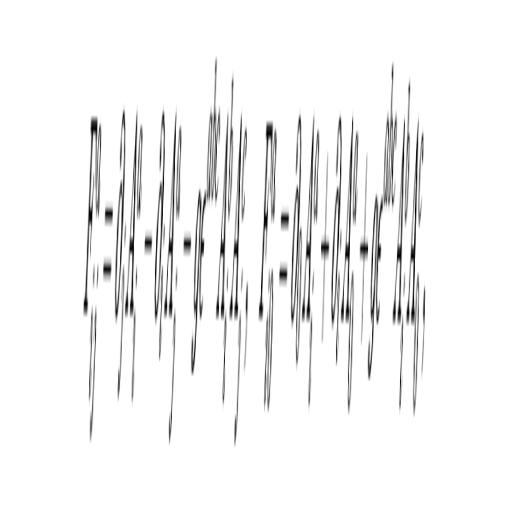

 <S> F _ { i j } ^ { a } = \partial _ { j } A _ { i } ^ { a } - \partial _ { i } A _ { j } ^ { a } - g { \epsilon } ^ { a b c } A _ { i } ^ { b } A _ { j } ^ { c } \, , \; \; \, F _ { i 0 } ^ { a } = \partial _ { 0 } A _ { i } ^ { a } + \partial _ { i } A _ { 0 } ^ { a } + g { \epsilon } ^ { a b c } A _ { i } ^ { b } A _ { 0 } ^ { c } \, , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>

Predicted formula: 



Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/gregory/miniforge3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/gregory/miniforge3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Data/Data_Module.py", line 7, in <module>
    import pytorch_lightning as pl
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/pytorch_lightning/__init__.py", line 20, in <module>
    from pytorch_lightning.callbacks import Callback  # noqa: E402
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/pytorch_lightning/callbacks/__init__.py", line 14, in <module>
    from pytorch_lightning.callbacks.base import Callback
  File "/Users/gregory/miniforge3/lib/python3.9/site-packages/pytorch_lightning/callbacks/base.py", line 26, in <module>
    from pytorch_

 <S> { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { 



<IPython.core.display.Math object>

None


In [11]:
# Get image and label from train data -- change number for different ones
image_tensor, label = dataset.data_train[12]
transform = transforms.ToPILImage()
image = transform(image_tensor)

print('\nOriginal image and formula:')
display(image)
print(token_to_strings(label))
print('\nPredicted formula: \n')
with torch.no_grad():
    model.eval()
    prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(prediction),'\n')
print(display(Math(token_to_strings(prediction))))